## Import the libraries

In [190]:
import category_encoders as ce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam
import time


## Import the Dataset

In [2]:
cc_f = "creditcard_dataset/credit_card_transactions-ibm_v2.csv"
user_f = "creditcard_dataset/sd254_users.csv"
cc_df = pd.read_csv(cc_f)
user_df = pd.read_csv(user_f)

In [3]:
cc_df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No


In [4]:
user_df

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Jose Faraday,32,70,1987,7,Male,6577 Lexington Lane,9.0,Freeport,NY,11520,40.65,-73.58,$23550,$48010,$87837,703,3
1996,Ximena Richardson,62,65,1957,11,Female,2 Elm Drive,955.0,Independence,KY,41051,38.95,-84.54,$24218,$49378,$104480,740,4
1997,Annika Russell,47,67,1973,1,Female,276 Fifth Boulevard,NaN,Elizabeth,NJ,7201,40.66,-74.19,$15175,$30942,$71066,779,3
1998,Juelz Roman,66,60,1954,2,Male,259 Valley Boulevard,NaN,Camp Hill,PA,17011,40.24,-76.92,$25336,$54654,$27241,618,1


## Check/Clean for missing Values

In [5]:
cc_df.loc[cc_df['Merchant State'].isna()]

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
11,0,0,2002,9,5,20:41,$53.91,Online Transaction,-9092677072201095172,ONLINE,NaN,NaN,4900,NaN,No
24,0,0,2002,9,9,20:02,$144.90,Online Transaction,-8338381919281017248,ONLINE,NaN,NaN,4899,NaN,No
85,0,0,2002,9,30,06:21,$127.32,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,NaN,No
99,0,0,2002,10,6,06:14,$139.39,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,NaN,No
106,0,0,2002,10,9,08:16,$53.09,Online Transaction,-4956618006720593695,ONLINE,NaN,NaN,5193,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386877,1999,1,2020,2,24,20:04,$55.79,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
24386879,1999,1,2020,2,25,07:06,$43.08,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
24386880,1999,1,2020,2,25,07:34,$43.76,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
24386884,1999,1,2020,2,26,07:43,$45.18,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No


It looks like all of the missing values for Merchant State are due to Online purchases, we will resolve this by labeling these missing values as ONLINE, similar to what is already found in Merchant City

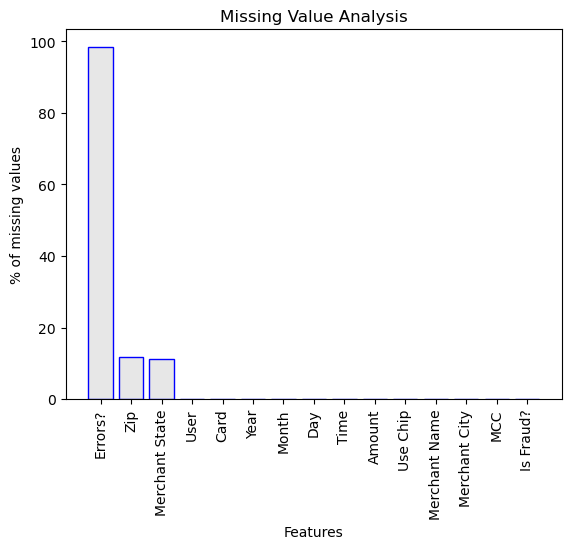

In [6]:
percent_missing=(cc_df.isnull().sum()*100/cc_df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)
plt.show()

In [7]:
cc_df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No


In [8]:
cc_df['Amount'] = cc_df['Amount'].str.replace("\\$", "", regex=True)
cc_df['Amount'] = pd.to_numeric(cc_df['Amount'], errors='coerce')
print(cc_df['Amount'].head(10))

0    134.09
1     38.48
2    120.34
3    128.95
4    104.71
5     86.19
6     93.84
7    123.50
8     61.72
9     57.10
Name: Amount, dtype: float64


In [9]:
cc_df['Errors?'].unique()

array([nan, 'Technical Glitch', 'Insufficient Balance', 'Bad PIN',
       'Bad PIN,Insufficient Balance', 'Bad Expiration',
       'Bad PIN,Technical Glitch', 'Bad Card Number', 'Bad CVV',
       'Bad Zipcode', 'Insufficient Balance,Technical Glitch',
       'Bad Card Number,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Insufficient Balance', 'Bad Card Number,Bad Expiration',
       'Bad Expiration,Bad CVV', 'Bad Expiration,Insufficient Balance',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration,Technical Glitch',
       'Bad CVV,Technical Glitch', 'Bad Card Number,Technical Glitch',
       'Bad Zipcode,Insufficient Balance', 'Bad Zipcode,Technical Glitch',
       'Bad Card Number,Bad Expiration,Insufficient Balance'],
      dtype=object)

## Clean the dataset


In [10]:
cc_df['Zip'] = cc_df['Zip'].astype(str)
cc_df.loc[cc_df['Merchant City'] == 'ONLINE', ['Merchant State', 'Zip']] = 'ONLINE'

In [11]:
cc_df.loc[cc_df['Zip'].isna(), 'Zip'] = 'Foreign'

In [12]:
cc_df.isna().any()

User              False
Card              False
Year              False
Month             False
Day               False
Time              False
Amount            False
Use Chip          False
Merchant Name     False
Merchant City     False
Merchant State    False
Zip               False
MCC               False
Errors?            True
Is Fraud?         False
dtype: bool

In [13]:
# Get a unique list of "States"
states = cc_df['Merchant State'].unique()

In [14]:
# Check the US States abbreviations
us_states = [state for state in states if len(str(state)) == 2]

In [15]:
us_states

['CA',
 'NE',
 'IL',
 'MO',
 'IA',
 'TX',
 'NJ',
 'NV',
 'NY',
 'AZ',
 'UT',
 'FL',
 'MI',
 'WA',
 'OH',
 'NM',
 'SC',
 'AK',
 'PA',
 'VA',
 'HI',
 'CT',
 'MA',
 'MN',
 'CO',
 'GA',
 'AR',
 'OR',
 'WI',
 'NC',
 'WV',
 'ME',
 'NH',
 'VT',
 'MD',
 'AL',
 'KY',
 'TN',
 'MS',
 'KS',
 'ND',
 'DC',
 'MT',
 'OK',
 'WY',
 'ID',
 'RI',
 'IN',
 'LA',
 'DE',
 'SD',
 'AA']

In [16]:
len(us_states)

52

It looks like there are 52 state abbreviations, including DC for District of Columbia and AA for Armed Forces of America

Let's map the days of the month to day of the week and separate the time column into hour and minute

In [17]:
# Get the day of the month

cc_df['Date'] =  pd.to_datetime(cc_df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
cc_df['Day of Week'] = cc_df['Date'].dt.dayofweek.map(days)


In [18]:
# Get the hour and minute from Time
cc_df['Hour'] = pd.to_numeric(cc_df['Time'].str [0:2])
cc_df['Minute'] = pd.to_numeric(cc_df['Time'].str [3:5])

In [19]:
cc_df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Date,Day of Week,Hour,Minute
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,2002-09-01,Sun,6,21
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,2002-09-01,Sun,6,42
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,2002-09-02,Mon,6,22
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,2002-09-02,Mon,17,45
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,2002-09-03,Tue,6,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No,2020-02-27,Thu,22,23
24386896,1999,1,2020,2,27,22:24,54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No,2020-02-27,Thu,22,24
24386897,1999,1,2020,2,28,07:43,59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No,2020-02-28,Fri,7,43
24386898,1999,1,2020,2,28,20:10,43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No,2020-02-28,Fri,20,10


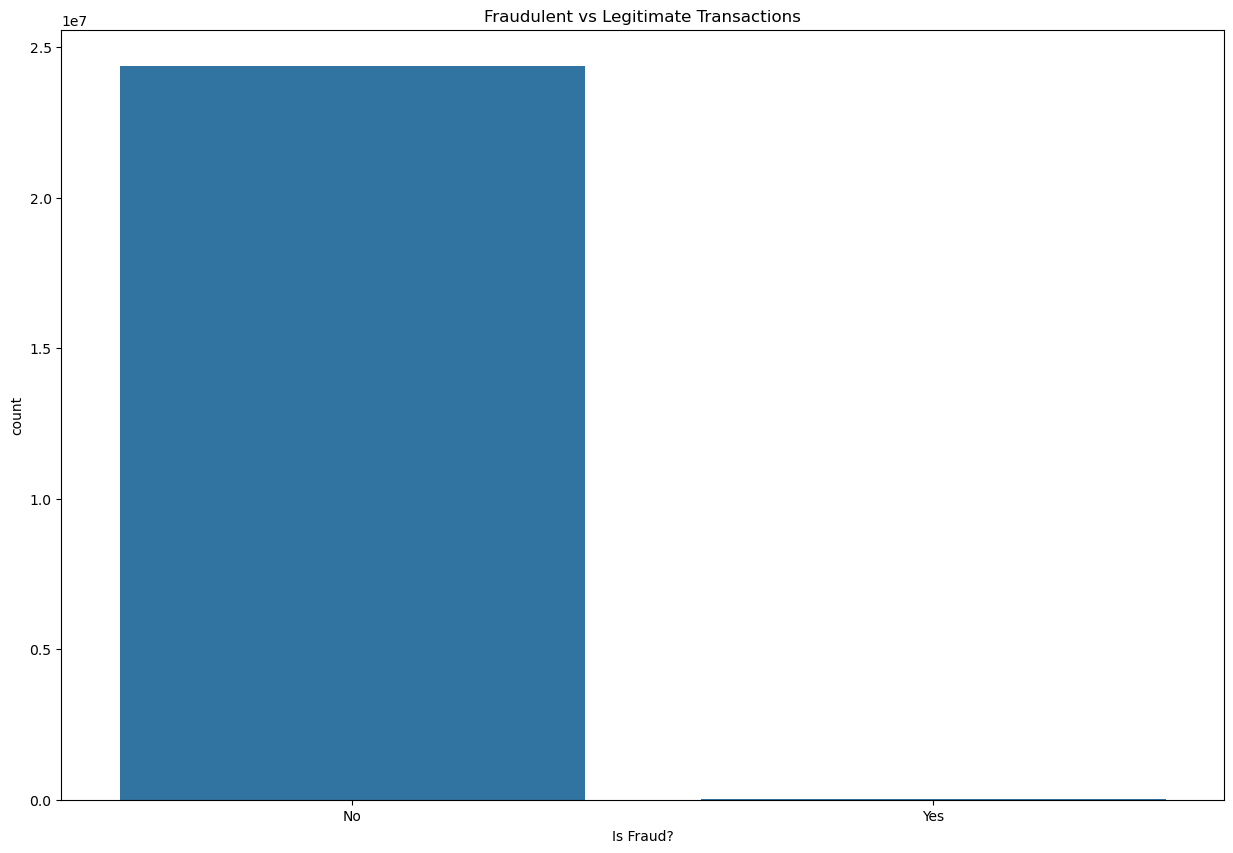

In [20]:
# Fraudulent vs legitimate transactions
plt.figure(figsize=(15, 10))
sns.countplot(data=cc_df, x='Is Fraud?')
plt.title('Fraudulent vs Legitimate Transactions')
plt.show()

As we can see, this dataset is heavily imbalanced, with the number of legitimate transactions far exceeding fraudulent.

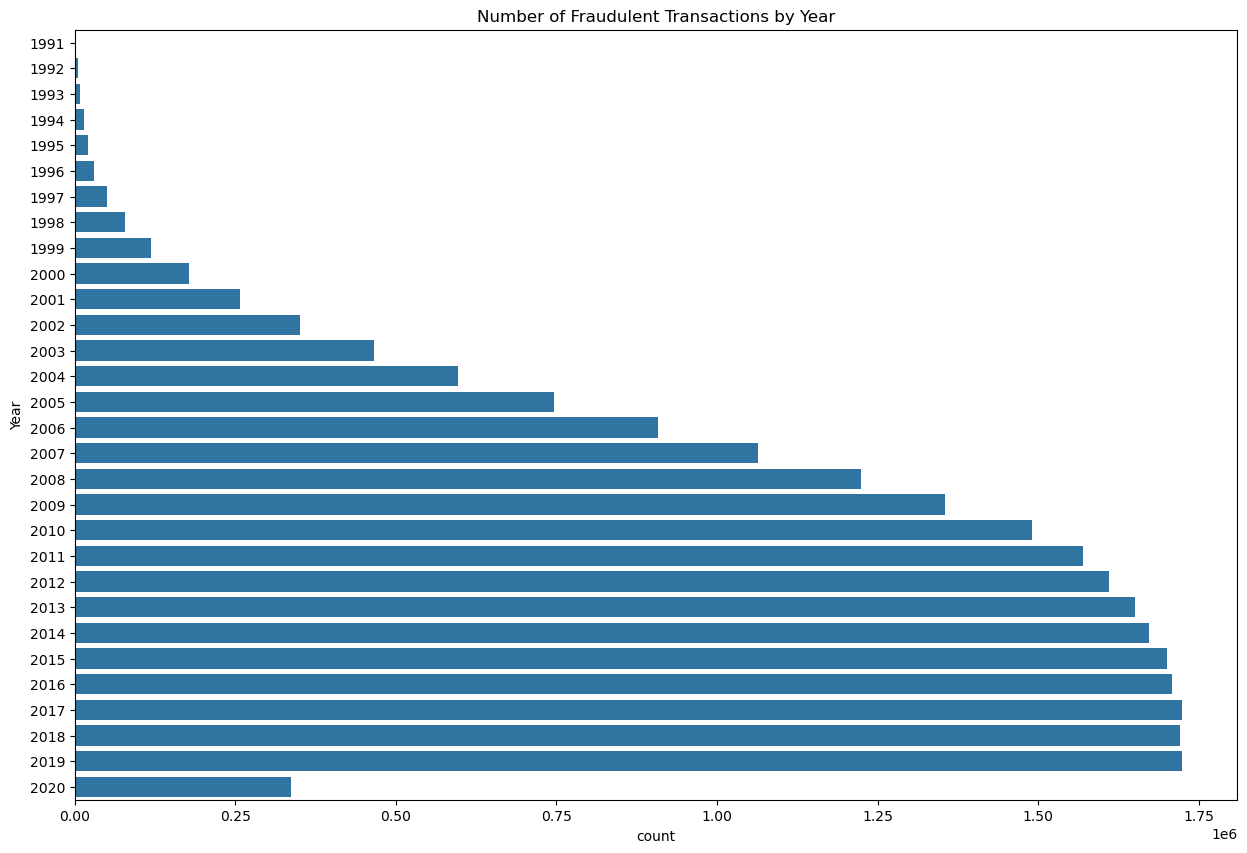

In [21]:
plt.figure(figsize=(15, 10))  
sns.countplot(data=cc_df, y='Year')
plt.title('Number of Fraudulent Transactions by Year')
plt.show()

It looks like the number of fraudulent transactions increases year over year. I want to confirm that we do not have full yearly data for 2020. 

In [22]:
cc_df['Date'].max()

Timestamp('2020-02-28 00:00:00')

The latest date we have for 2020 is February 28th, indicating that we do not have a full year's worth of data for 2020. 

## Fraudulent Transactions Analysis
Let's take a look at the amounts of the fraudulent transactions.

In [23]:
cc_df['Is Fraud?'] = cc_df['Is Fraud?'].map({'No': 0, 'Yes': 1})
cc_df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Date,Day of Week,Hour,Minute
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,0,2002-09-01,Sun,6,21
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,0,2002-09-01,Sun,6,42
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,0,2002-09-02,Mon,6,22
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,0,2002-09-02,Mon,17,45
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,0,2002-09-03,Tue,6,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,0,2020-02-27,Thu,22,23
24386896,1999,1,2020,2,27,22:24,54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,0,2020-02-27,Thu,22,24
24386897,1999,1,2020,2,28,07:43,59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,0,2020-02-28,Fri,7,43
24386898,1999,1,2020,2,28,20:10,43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,0,2020-02-28,Fri,20,10


In [24]:
# Create a fraud_df that has all of the fraudulent transactions
fraud_df = cc_df.loc[cc_df['Is Fraud?'] == 1].copy()
# Set the bins for transaction amounts that will be used in graphing
bins = bin_edges = range(0, int(fraud_df['Amount'].max()) + 100, 100)
fraud_df['Amount Bin'] = pd.cut(fraud_df['Amount'], bins=bin_edges)

In [25]:
# Get the number of fraud in each bin
fraud_count = fraud_df.groupby('Amount Bin', observed=True).size()


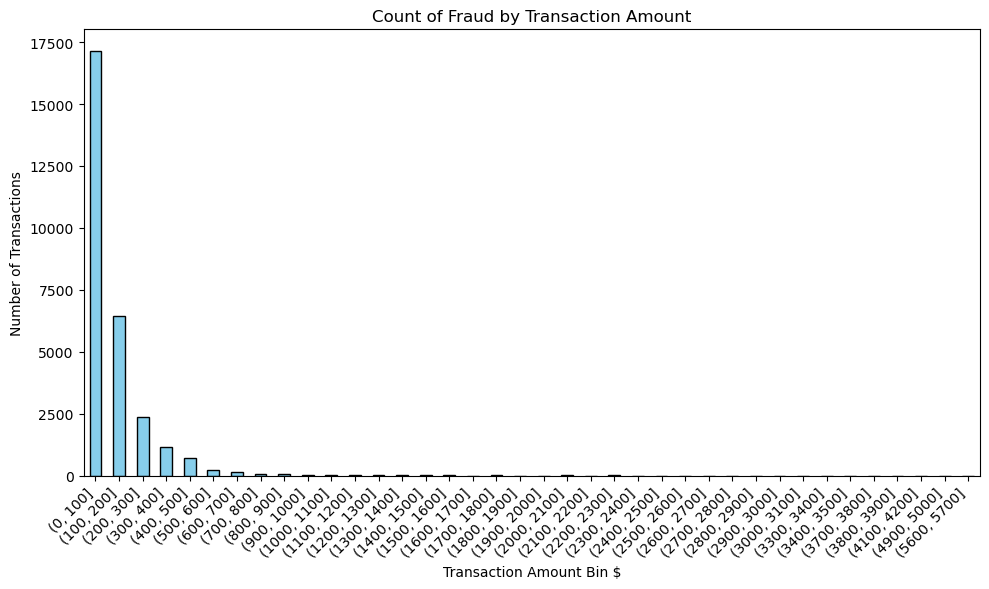

In [26]:
# Plot the figure
plt.figure(figsize=(10,6))
fraud_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Fraud by Transaction Amount')
plt.xlabel('Transaction Amount Bin $')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From the above graph, we can see that the vast majority of fraudulent transactions are less than $100. 
Let's take a look at locations next, we will start with State (which is also Country). Additionally, we have modified the Merchant State column to include Online information. 

In [27]:
fraud_df['Merchant State'].unique()

array(['ONLINE', 'CA', 'NY', 'Italy', 'Haiti', 'Algeria', 'OH', 'MI',
       'OK', 'TX', 'NE', 'CO', 'AZ', 'IN', 'Nigeria', 'Mexico', 'Tuvalu',
       'TN', 'FL', 'MA', 'KS', 'GA', 'NJ', 'SC', 'WA', 'UT', 'MD', 'PA',
       'AL', 'Turkey', 'IL', 'Japan', 'NC', 'HI', 'IA', 'DE', 'ID', 'MN',
       'VA', 'MS', 'KY', 'WI', 'CT', 'VT', 'AR', 'NV', 'Fiji', 'NM', 'LA',
       'OR', 'MO', 'AK', 'SD', 'ND', 'ME', 'WV', 'NH', 'India', 'WY',
       'MT', 'RI'], dtype=object)

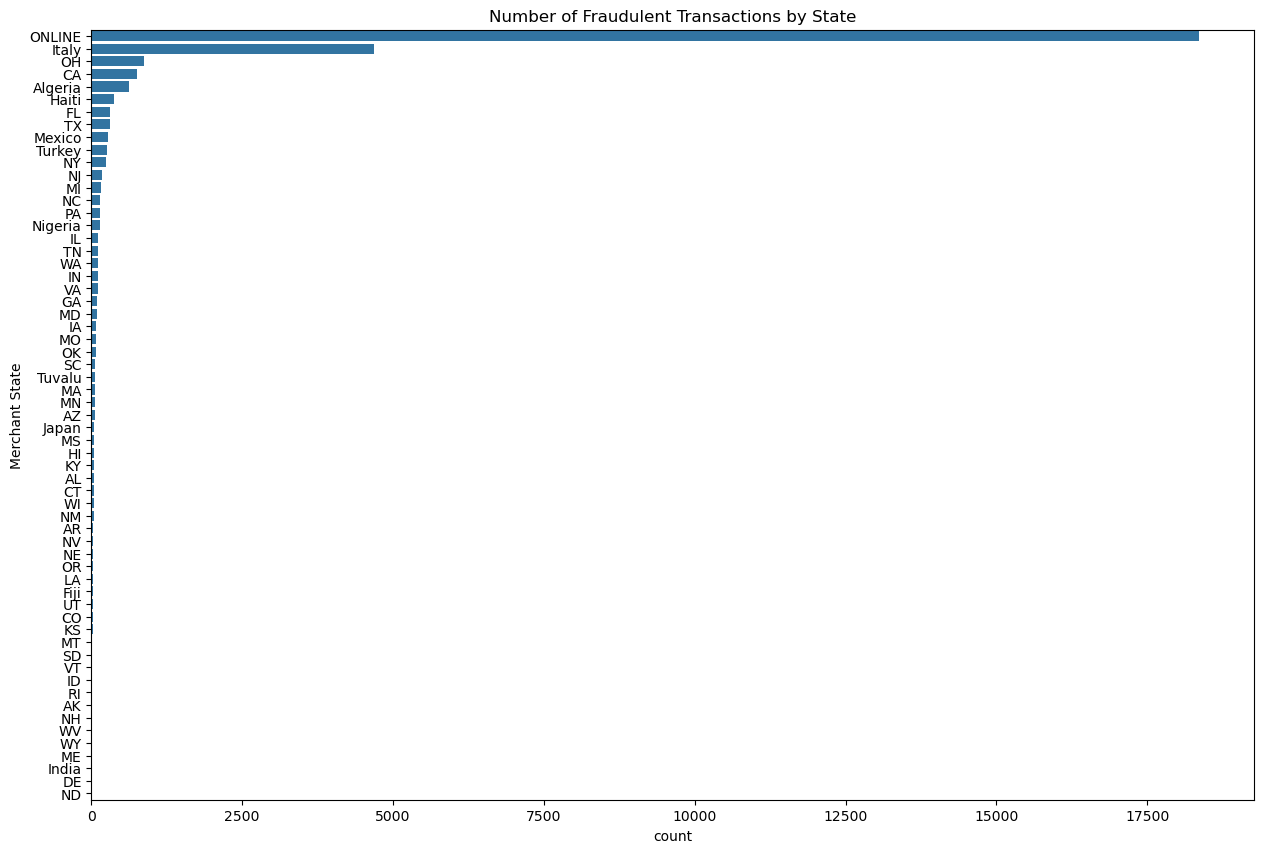

In [28]:
# Number of fraudulent transactions by State/Country
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_df, y='Merchant State', order=fraud_df['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by State')
plt.show()

As we can see from the graph above, the majority of fraudulent transactions were made online. In second place we have Italy, and in third Ohio. 

In [29]:
fraud_df['Year'].unique()

array([2015, 2016, 2008, 2019, 2010, 2006, 2018, 2013, 2017, 2001, 2014,
       2009, 2007, 2005, 2000, 2012, 2002, 1999, 2004, 2003, 2011, 1997,
       1998, 1996])

## Date/Time Fraud Analysis

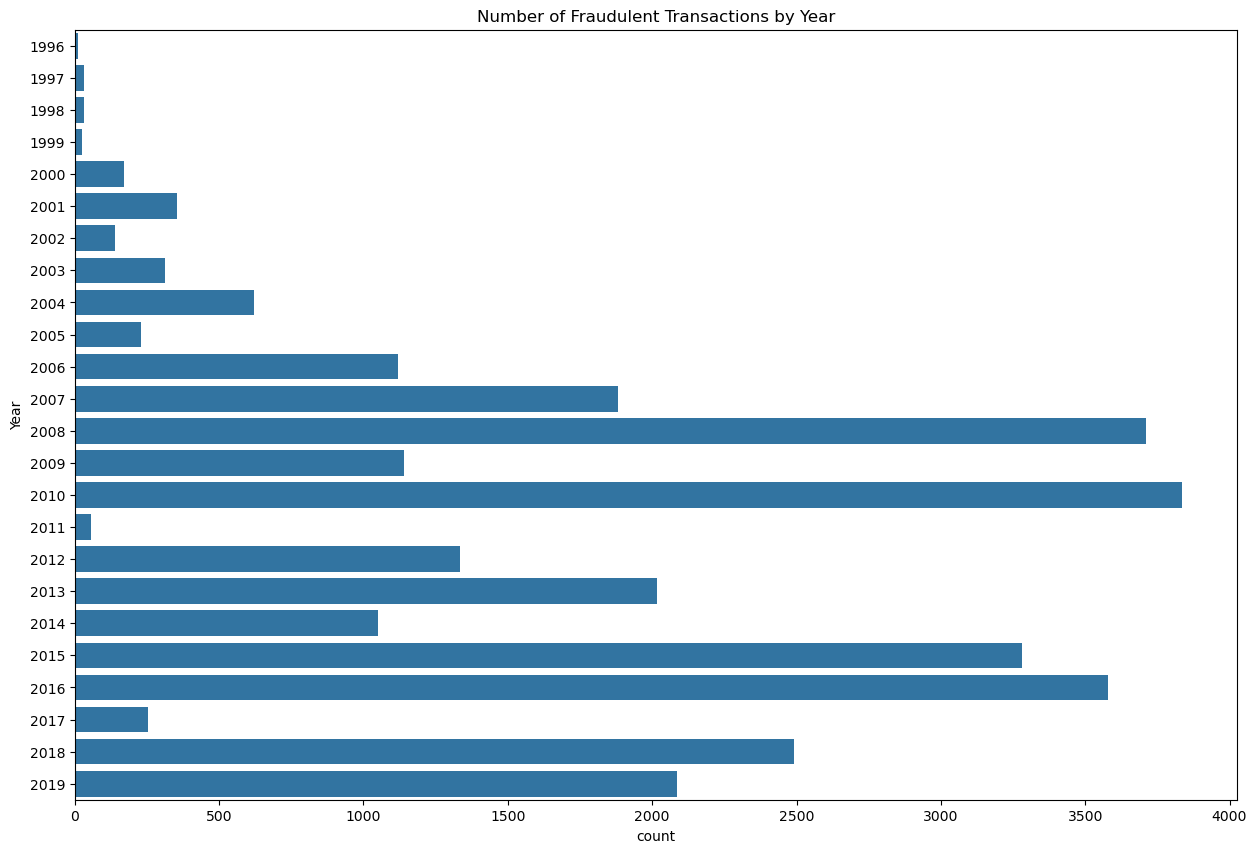

In [30]:
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_df, y='Year')
plt.title('Number of Fraudulent Transactions by Year')
plt.show()

We can see that the majority of fraudulent transactions occured in 2010, 2008, and 2016. 

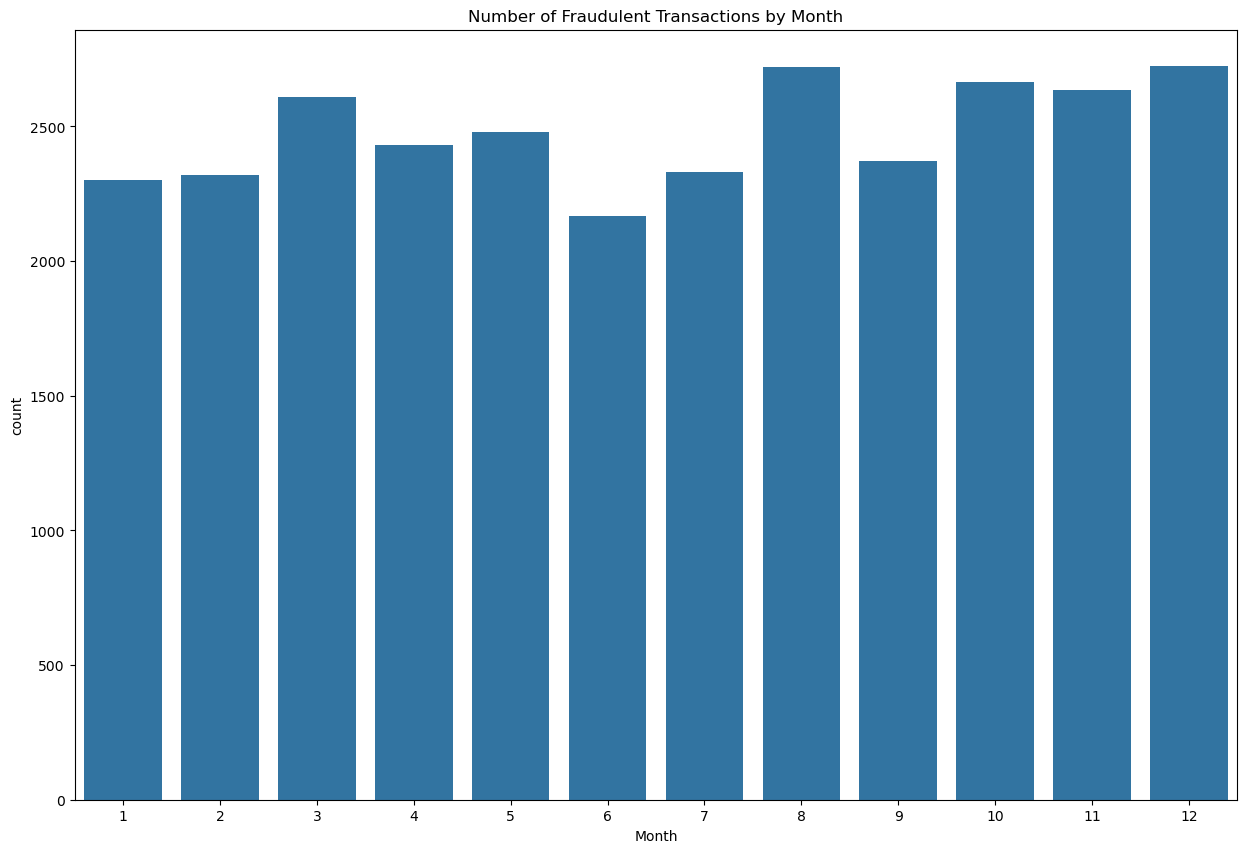

In [31]:
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_df, x='Month')
plt.title('Number of Fraudulent Transactions by Month')
plt.show()

Here, we can see that the end of the year has slightly higher rates of fraudulent transactions, but it is not a very clear trend.

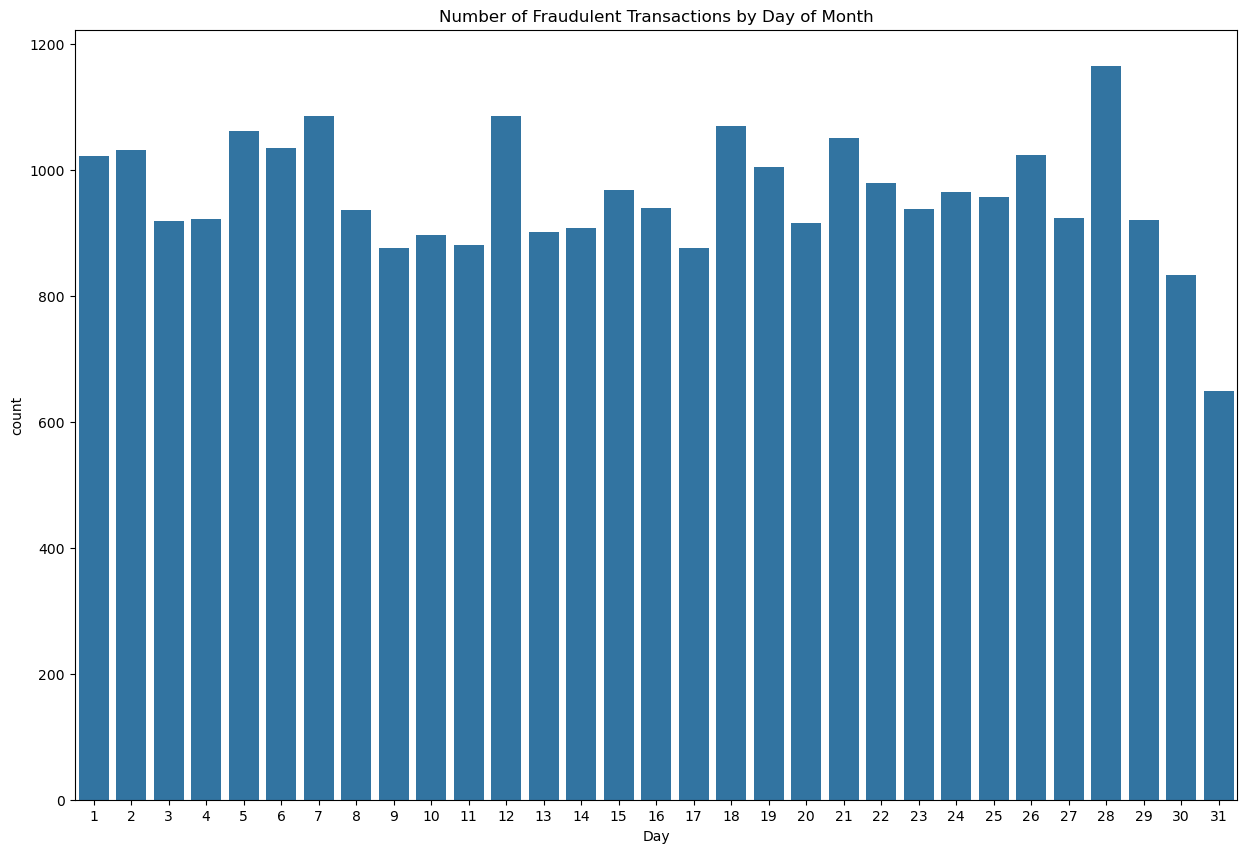

In [32]:
# Graph for Day of the Month
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_df, x='Day')
plt.title('Number of Fraudulent Transactions by Day of Month')
plt.show()

We can see that while the 28th has the highest rate, there are not clearly defined patterns of increased fraud associated with a particular day of the month. 

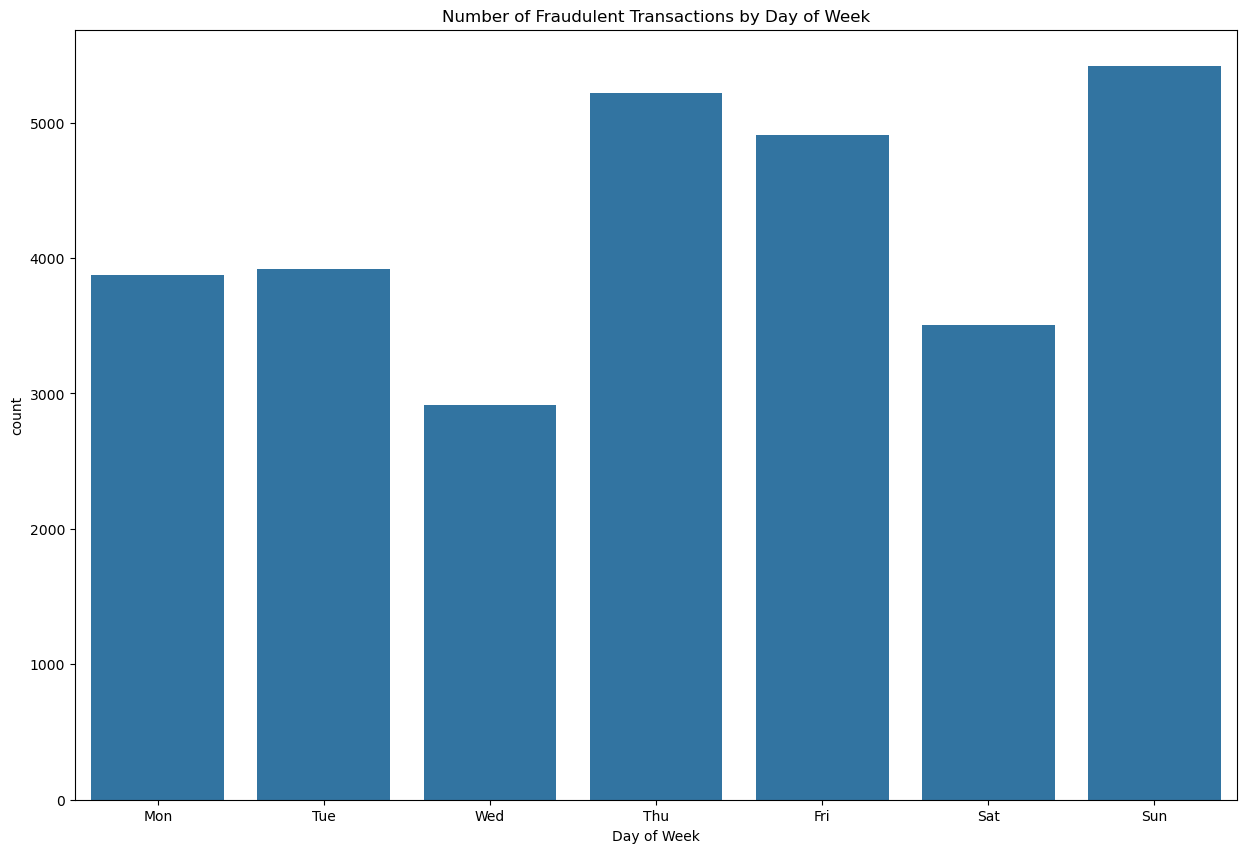

In [33]:
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_df, x='Day of Week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Number of Fraudulent Transactions by Day of Week')
plt.show()

From the above graph, we can see that Sunday, Thursday, and Friday all see elevated rates of fraud. 

In [34]:
len(fraud_df['Hour'].unique())

24

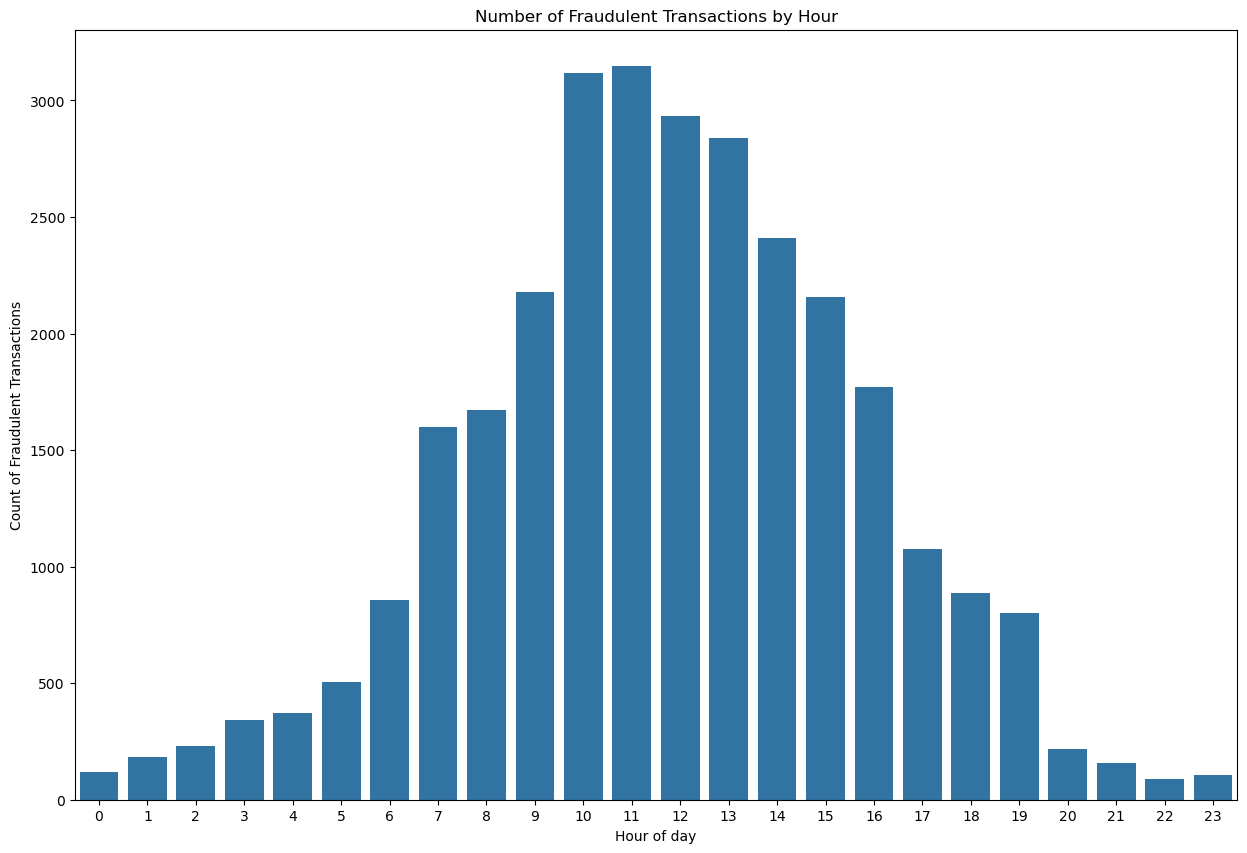

In [35]:
# Let's look at fraudulent activity based on the hours of the day
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_df, x='Hour', order=range(0, 24))  # 0 to 12 inclusive
plt.title('Number of Fraudulent Transactions by Hour')
plt.xlabel('Hour of day')
plt.ylabel('Count of Fraudulent Transactions')
plt.xticks(range(0, 24), labels=range(0, 24))
plt.show()

From the graph above, we can see that most of fraudulent transactions occur between 10-12 in this dataset. 

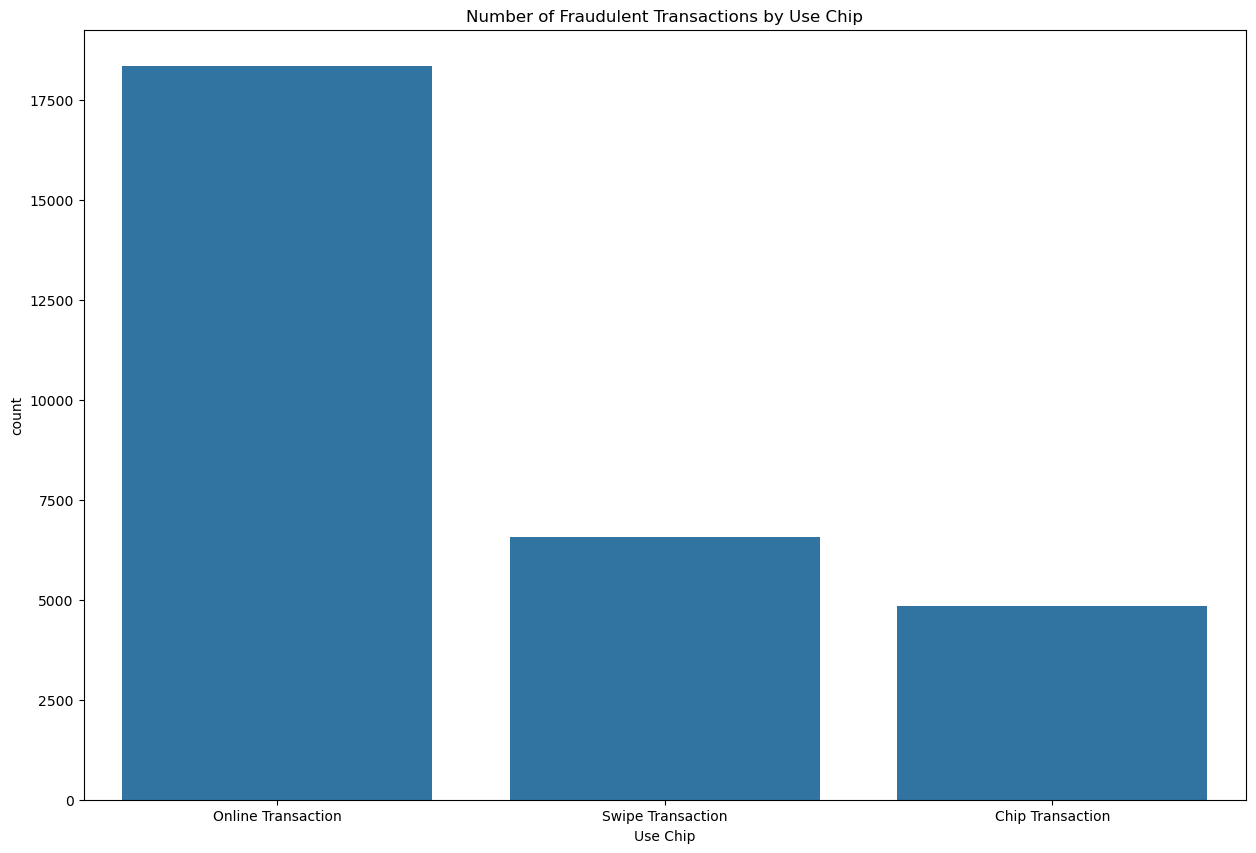

In [36]:
# Graph of use chip
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_df, x='Use Chip', order=fraud_df['Use Chip'].value_counts().index)
plt.title('Number of Fraudulent Transactions by Use Chip')
plt.show()

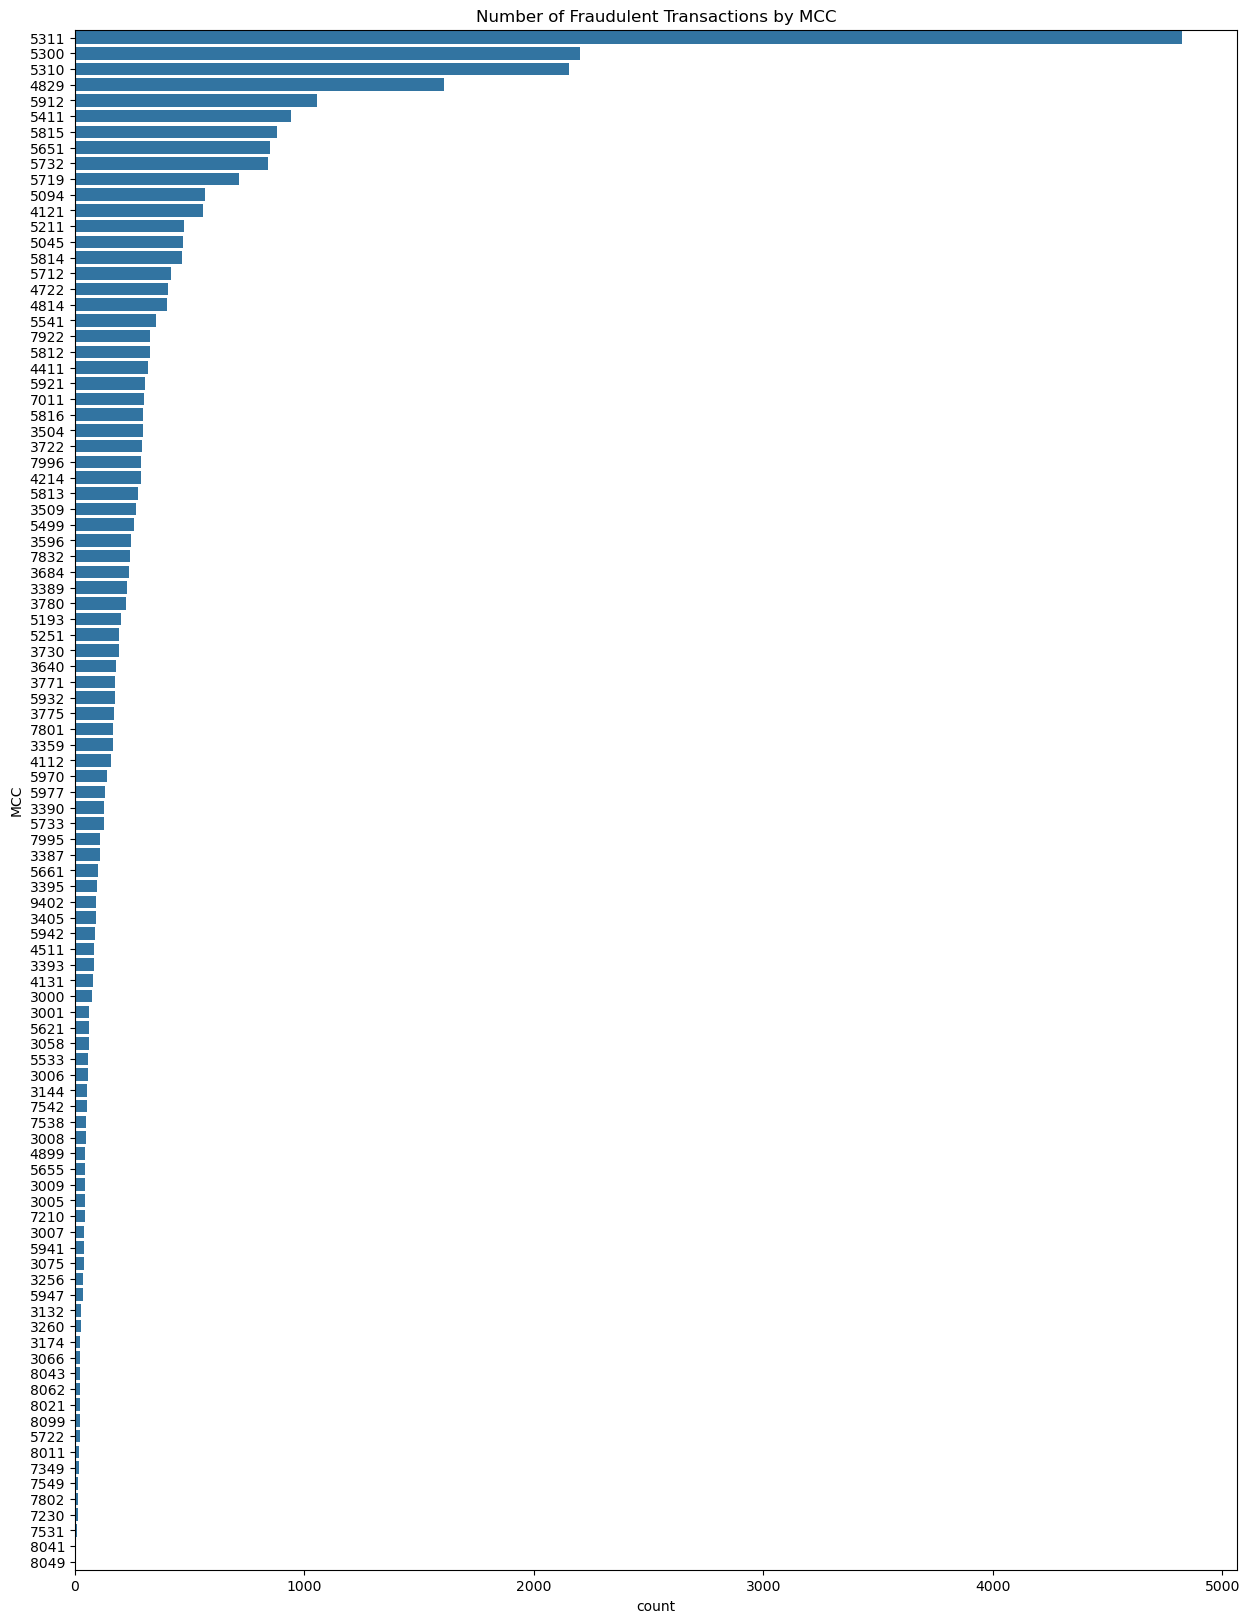

In [37]:
plt.figure(figsize=(15, 20))  
sns.countplot(data=fraud_df, y='MCC', order=fraud_df['MCC'].value_counts().index)
plt.title('Number of Fraudulent Transactions by MCC')
plt.show()

## Feature Selection
Looking at the above analysis, the following features are good candidates to include in our models:
<ul>
    <li>Year</li>
    <li>Amount</li>
    <li>State</li>
    <li>Day of Week</li>
    <li>Hour</li> 
    <li>Use Chip</li>
    <li>MCC</li>
</ul>


## Model Creation

In [38]:
# Create a list of features that will be used by the model. 
model_cols = ['Year', 'Day of Week', 'Hour', 'Amount', 'Merchant State', 'Use Chip', 'MCC', 'Is Fraud?']

In [39]:
# Create the dataset to be used by the models
model_df = cc_df.loc[:,model_cols]
model_df

,Year,Day of Week,Hour,Amount,Merchant State,Use Chip,MCC,Is Fraud?
0,2002,Sun,6,134.09,CA,Swipe Transaction,5300,0
1,2002,Sun,6,38.48,CA,Swipe Transaction,5411,0
2,2002,Mon,6,120.34,CA,Swipe Transaction,5411,0
3,2002,Mon,17,128.95,CA,Swipe Transaction,5651,0
4,2002,Tue,6,104.71,CA,Swipe Transaction,5912,0
...,...,...,...,...,...,...,...,...
24386895,2020,Thu,22,-54.00,NH,Chip Transaction,5541,0
24386896,2020,Thu,22,54.00,NH,Chip Transaction,5541,0
24386897,2020,Fri,7,59.15,NH,Chip Transaction,4121,0
24386898,2020,Fri,20,43.12,NH,Chip Transaction,4121,0


## Encode the data


In [40]:
# Encode the categorical variables with a binary encoder
model_df.dtypes

Year                int64
Day of Week        object
Hour                int64
Amount            float64
Merchant State     object
Use Chip           object
MCC                 int64
Is Fraud?           int64
dtype: object

In [41]:
# Convert columns to the appropriate dtype
model_df['MCC'] = model_df['MCC'].astype('category')

# Encode the Object columns accordingly
model_df = pd.get_dummies(model_df, columns=['Day of Week', 'Use Chip'], prefix="Day")

# Create a binary encoder
binary_encoder = ce.BinaryEncoder(cols=['Merchant State', 'MCC'])
model_df = binary_encoder.fit_transform(model_df)

# Sine-Cosine Encoding for Hour and Year
model_df['Hour_Sin'] = np.sin(2 * np.pi * model_df['Hour'] / 24)
model_df['Hour_Cos'] = np.cos(2 * np.pi * model_df['Hour'] /24)
model_df.drop(columns='Hour', inplace=True)

target_column = "Is Fraud?"

model_df


,Year,Amount,Merchant State_0,Merchant State_1,Merchant State_2,Merchant State_3,Merchant State_4,Merchant State_5,Merchant State_6,Merchant State_7,...,Day_Sat,Day_Sun,Day_Thu,Day_Tue,Day_Wed,Day_Chip Transaction,Day_Online Transaction,Day_Swipe Transaction,Hour_Sin,Hour_Cos
0,2002,134.09,0,0,0,0,0,0,0,1,...,False,True,False,False,False,False,False,True,1.000000,6.123234e-17
1,2002,38.48,0,0,0,0,0,0,0,1,...,False,True,False,False,False,False,False,True,1.000000,6.123234e-17
2,2002,120.34,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,True,1.000000,6.123234e-17
3,2002,128.95,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,True,-0.965926,-2.588190e-01
4,2002,104.71,0,0,0,0,0,0,0,1,...,False,False,False,True,False,False,False,True,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,2020,-54.00,0,0,1,0,1,1,1,1,...,False,False,True,False,False,True,False,False,-0.500000,8.660254e-01
24386896,2020,54.00,0,0,1,0,1,1,1,1,...,False,False,True,False,False,True,False,False,-0.500000,8.660254e-01
24386897,2020,59.15,0,0,1,0,1,1,1,1,...,False,False,False,False,False,True,False,False,0.965926,-2.588190e-01
24386898,2020,43.12,0,0,1,0,1,1,1,1,...,False,False,False,False,False,True,False,False,-0.866025,5.000000e-01


## Split the data

In [ ]:
# Split the features from the target variable
X = model_df.drop(columns=['Is Fraud?']) # Features
y = model_df['Is Fraud?'] # Target

# Create the train and  test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data for the Random Forest Classifier and LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest Classifier


In [236]:
# Time the model
start_rf = time.time()

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

end_rf = time.time()
rf_time = end_rf - start_rf

print(f"Operation took {rf_time:.2f} seconds.")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Operation took 1600.16 seconds.


In [237]:
# Evaluate the model
print('Random Forest Classification Report')
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Random Forest Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4871336
           1       0.29      0.41      0.34      6044

    accuracy                           1.00   4877380
   macro avg       0.65      0.70      0.67   4877380
weighted avg       1.00      1.00      1.00   4877380

Accuracy: 0.9980454670335303


## LSTM Neural Network


In [86]:
# Make sure that my GPU is available
print(f"Num GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))



Num GPUs available: 1


NameError: name 'X_train_scaled' is not defined

In [87]:
# Build the LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    # Add the first LSTM layer
    model.add(LSTM(200, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3)) # Dropout to avoid overfitting
    # Add the second LSTM layer
    model.add(LSTM(200, activation='tanh', return_sequences=False))
    # Dense layers
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [413]:
# Build and train the model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
lstm_model = build_lstm_model(input_shape)

In [414]:
lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 200)            184000    
                                                                 
 dropout_28 (Dropout)        (None, 1, 200)            0         
                                                                 
 lstm_16 (LSTM)              (None, 200)               320800    
                                                                 
 dense_28 (Dense)            (None, 32)                6432      
                                                                 
 dropout_29 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 511265 (1.95 MB)
Trainable params: 5112

In [415]:
# Use EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Time the training process
start_time = time.time()
history = lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=64, validation_split=0.2, shuffle=True, callbacks=[early_stopping])
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/20
 19438/243869 [=>............................] - ETA: 31:02 - loss: 0.0071 - accuracy: 0.9989

In [ ]:
loss, accuracy = lstm_model.evaluate(X_test_lstm, y_test, batch_size=16, verbose=1)


In [243]:
print(f"Test loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test loss: 0.6976
Test Accuracy: 0.4813


In [244]:
lstm_pred = lstm_model.predict(X_test_lstm)

152419/152419 [==============================] - 310s 2ms/step


In [245]:
# Convert probabilities to binary predictions (0 or 1)
threshold = 0.5
binary_predictions = (lstm_pred > threshold).astype(int)

In [246]:
# Classification Report
print(classification_report(y_test, binary_predictions)

# Confusion Matrix
print(f"Confusion Matrix: {confusion_matrix(y_test, binary_predictions)}")

Classifcation Report:               precision    recall  f1-score   support

           0       1.00      0.48      0.65   4871336
           1       0.00      0.45      0.00      6044

    accuracy                           0.48   4877380
   macro avg       0.50      0.46      0.33   4877380
weighted avg       1.00      0.48      0.65   4877380

Confusion Matrix: [[2344746 2526590]
 [   3351    2693]]


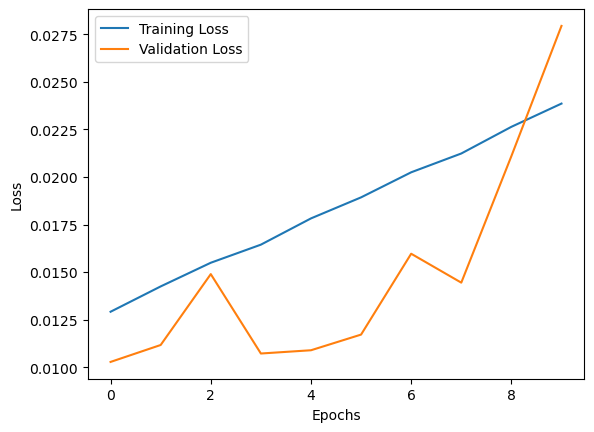

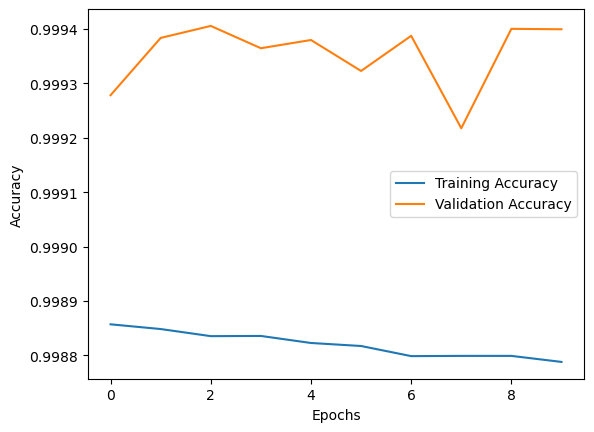

In [247]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

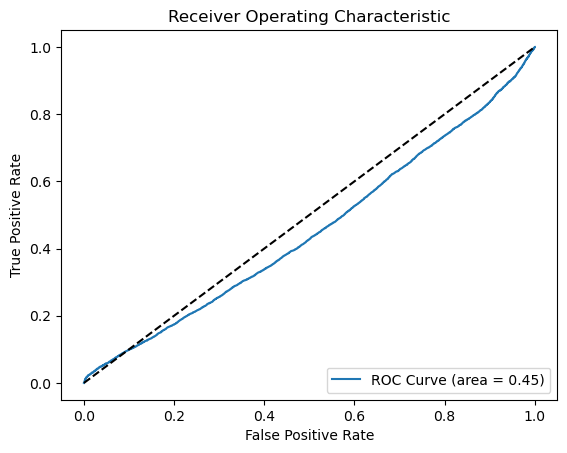

In [248]:
# Get the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lstm_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [249]:
# Save the model
lstm_model.save('lstm_fraud_model_with_early_stopping.keras')

# Loading the model
# from tensorflow.keras.models import load_model
# model = load_model('lstm_fraud_model.h5')

## Online Transactions Model

Since we are dealing with a heavily imbalanced dataset, let's investigate whether we can improve our model's balance by focusing exclusively on online transactions where most of the fraud occurs. 

In [120]:
cc_df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Date,Day of Week,Hour,Minute
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,0,2002-09-01,Sun,6,21
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,0,2002-09-01,Sun,6,42
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,0,2002-09-02,Mon,6,22
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,0,2002-09-02,Mon,17,45
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,0,2002-09-03,Tue,6,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,0,2020-02-27,Thu,22,23
24386896,1999,1,2020,2,27,22:24,54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,0,2020-02-27,Thu,22,24
24386897,1999,1,2020,2,28,07:43,59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,0,2020-02-28,Fri,7,43
24386898,1999,1,2020,2,28,20:10,43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,0,2020-02-28,Fri,20,10


In [121]:
online_model_cols = ['User', 'Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'MCC', 'Is Fraud?']
online_df = cc_df.loc[:,online_model_cols]
online_df = online_df.loc[cc_df['Merchant State'] == 'ONLINE']

In [122]:
print(f"There are {cc_df.shape[0]} records in the cc_df and {online_df.shape[0]} records in the online_df.")
print(f"We have eliminated {cc_df.shape[0] - online_df.shape[0]} records by using the online_df.")

There are 24386900 records in the cc_df and 2720821 records in the online_df.
We have eliminated 21666079 records by using the online_df.


In [123]:
online_df.shape

(2720821, 8)

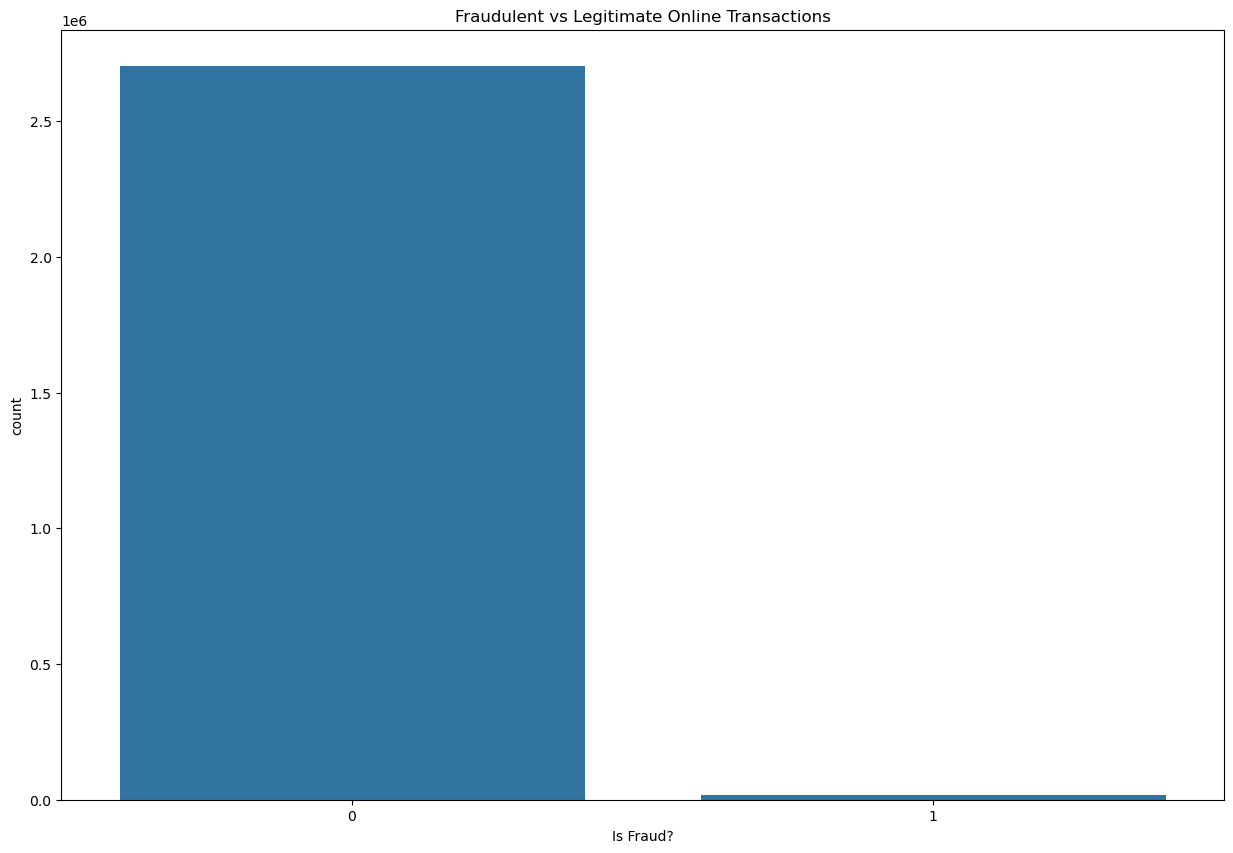

In [124]:
# Fraudulent vs legitimate transactions
plt.figure(figsize=(15, 10))
sns.countplot(data=online_df, x='Is Fraud?')
plt.title('Fraudulent vs Legitimate Online Transactions')
plt.show()

## Online Model Create - Random Forest

In [180]:
online_rf_df = online_df.copy()
online_rf_df

,User,Year,Day of Week,Hour,Amount,Use Chip,MCC,Is Fraud?
11,0,2002,Thu,20,53.91,Online Transaction,4900,0
24,0,2002,Mon,20,144.90,Online Transaction,4899,0
85,0,2002,Mon,6,127.32,Online Transaction,5311,0
99,0,2002,Sun,6,139.39,Online Transaction,5311,0
106,0,2002,Wed,8,53.09,Online Transaction,5193,0
...,...,...,...,...,...,...,...,...
24386877,1999,2020,Mon,20,55.79,Online Transaction,4121,0
24386879,1999,2020,Tue,7,43.08,Online Transaction,4121,0
24386880,1999,2020,Tue,7,43.76,Online Transaction,4121,0
24386884,1999,2020,Wed,7,45.18,Online Transaction,4121,0


In [181]:
# Target encode the user features
user_target_mean = online_rf_df.groupby('User')['Is Fraud?'].mean()
online_rf_df['User_encoded'] = online_rf_df['User'].map(user_target_mean)
online_rf_df = online_rf_df.drop(columns=['User'])
# Convert columns to the appropriate dtype
online_rf_df['MCC'] = online_rf_df['MCC'].astype('category')

# Encode the Object columns accordingly
online_rf_df = pd.get_dummies(online_rf_df, columns=['Day of Week', 'Use Chip'], prefix="Day")

# Create a binary encoder
rf_binary_encoder = ce.BinaryEncoder(cols=['MCC'])
online_rf_df = rf_binary_encoder.fit_transform(online_rf_df)

# Sine-Cosine Encoding for Hour and Year
online_rf_df['Hour_Sin'] = np.sin(2 * np.pi * online_rf_df['Hour'] / 24)
online_rf_df['Hour_Cos'] = np.cos(2 * np.pi * online_rf_df['Hour'] /24)
online_rf_df.drop(columns='Hour', inplace=True)

rf_target_column = "Is Fraud?"

online_rf_df


,Year,Amount,MCC_0,MCC_1,MCC_2,MCC_3,MCC_4,MCC_5,MCC_6,Is Fraud?,...,Day_Mon,Day_Sat,Day_Sun,Day_Thu,Day_Tue,Day_Wed,Day_Chip Transaction,Day_Online Transaction,Hour_Sin,Hour_Cos
11,2002,53.91,0,0,0,0,0,0,1,0,...,False,False,False,True,False,False,False,True,-0.866025,5.000000e-01
24,2002,144.90,0,0,0,0,0,1,0,0,...,True,False,False,False,False,False,False,True,-0.866025,5.000000e-01
85,2002,127.32,0,0,0,0,0,1,1,0,...,True,False,False,False,False,False,False,True,1.000000,6.123234e-17
99,2002,139.39,0,0,0,0,0,1,1,0,...,False,False,True,False,False,False,False,True,1.000000,6.123234e-17
106,2002,53.09,0,0,0,0,1,0,0,0,...,False,False,False,False,False,True,False,True,0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386877,2020,55.79,0,0,1,0,1,0,0,0,...,True,False,False,False,False,False,False,True,-0.866025,5.000000e-01
24386879,2020,43.08,0,0,1,0,1,0,0,0,...,False,False,False,False,True,False,False,True,0.965926,-2.588190e-01
24386880,2020,43.76,0,0,1,0,1,0,0,0,...,False,False,False,False,True,False,False,True,0.965926,-2.588190e-01
24386884,2020,45.18,0,0,1,0,1,0,0,0,...,False,False,False,False,False,True,False,True,0.965926,-2.588190e-01


In [182]:
# Split the features from the target variable
rf_X = online_rf_df.drop(columns=[rf_target_column])
rf_y = online_rf_df[rf_target_column]

# Train Test Split
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X, rf_y, test_size=0.2, random_state=42, stratify=rf_y)


In [183]:
# Create RF Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

# Fit the model
rf_model.fit(rf_X_train, rf_y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [184]:
# Evaulate the model
rf_y_pred = rf_model.predict(rf_X_test)
rf_y_pred_proba = rf_model.predict_proba(rf_X_test)[:, 1]

In [191]:
rf_cm = confusion_matrix(rf_y_test, rf_y_pred)
print(f"Classification Report:\n{classification_report(rf_y_test, rf_y_pred)}")
print(f"Confusion Matrix:\n{rf_cm}")
print(f"ROC AUC Score:\n {roc_auc_score(rf_y_test, rf_y_pred_proba)}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    540495
           1       0.97      0.63      0.76      3670

    accuracy                           1.00    544165
   macro avg       0.99      0.81      0.88    544165
weighted avg       1.00      1.00      1.00    544165

Confusion Matrix:
[[540430     65]
 [  1366   2304]]
ROC AUC Score:
 0.9812301913275431


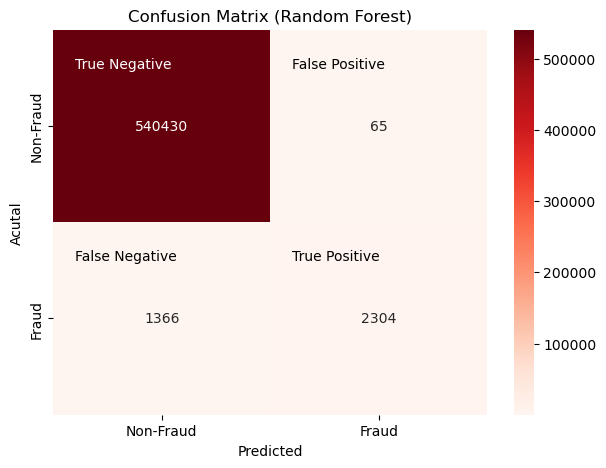

In [196]:
# Plot the confusion matrix
plt.figure(figsize=(7,5))
annotations = [f'TN: {rf_cm[0,0]}', f'FP: {online_cm[0,1]}'], [f'FN: {rf_cm[1,0]}', f'TP: {rf_cm[1,1]}']
hm = sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Acutal')
plt.title('Confusion Matrix (Random Forest)')
hm.text(0.1, 0.2, 'True Negative', color='white')
hm.text(1.1, 0.2, 'False Positive')
hm.text(0.1, 1.2, 'False Negative')
hm.text(1.1, 1.2, 'True Positive')
plt.show()

In [192]:
# Get the ROC Curve
rf_fpr, rf_tpr, rf_thresholds = roc_curve(rf_y_test, rf_y_pred_proba)
rf_roc_auc = auc(rf_fpr, rf_tpr)

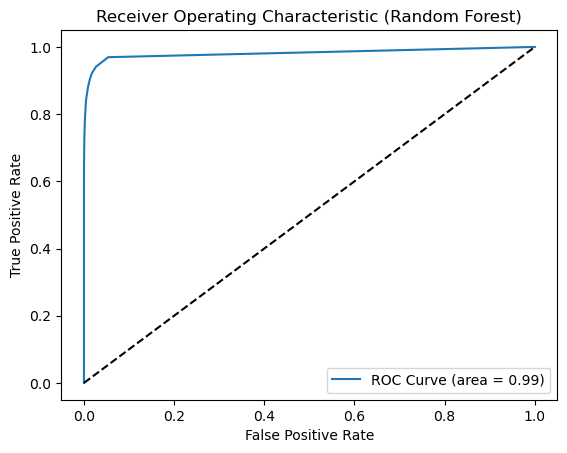

In [195]:
# Plot the ROC curve
plt.figure()
plt.plot(rf_fpr, rf_tpr, label=f'ROC Curve (area = {online_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Random Forest)')
plt.legend(loc='lower right')
plt.show()


## Online Model Creation - LSTM

In [198]:
# Create the dataset to be used by the models
online_model_df = online_df.copy()


## Encode the data

In [126]:
# Target encode the user features
user_target_mean = online_model_df.groupby('User')['Is Fraud?'].mean()
online_model_df['User_encoded'] = online_model_df['User'].map(user_target_mean)
online_model_df = online_model_df.drop(columns=['User'])
# Convert columns to the appropriate dtype
online_model_df['MCC'] = online_model_df['MCC'].astype('category')

# Encode the Object columns accordingly
online_model_df = pd.get_dummies(online_model_df, columns=['Day of Week', 'Use Chip'], prefix="Day")

# Create a binary encoder
online_binary_encoder = ce.BinaryEncoder(cols=['MCC'])
online_model_df = online_binary_encoder.fit_transform(online_model_df)

# Sine-Cosine Encoding for Hour and Year
online_model_df['Hour_Sin'] = np.sin(2 * np.pi * online_model_df['Hour'] / 24)
online_model_df['Hour_Cos'] = np.cos(2 * np.pi * online_model_df['Hour'] /24)
online_model_df.drop(columns='Hour', inplace=True)

online_target_column = "Is Fraud?"

online_model_df


,Year,Amount,MCC_0,MCC_1,MCC_2,MCC_3,MCC_4,MCC_5,MCC_6,Is Fraud?,...,Day_Mon,Day_Sat,Day_Sun,Day_Thu,Day_Tue,Day_Wed,Day_Chip Transaction,Day_Online Transaction,Hour_Sin,Hour_Cos
11,2002,53.91,0,0,0,0,0,0,1,0,...,False,False,False,True,False,False,False,True,-0.866025,5.000000e-01
24,2002,144.90,0,0,0,0,0,1,0,0,...,True,False,False,False,False,False,False,True,-0.866025,5.000000e-01
85,2002,127.32,0,0,0,0,0,1,1,0,...,True,False,False,False,False,False,False,True,1.000000,6.123234e-17
99,2002,139.39,0,0,0,0,0,1,1,0,...,False,False,True,False,False,False,False,True,1.000000,6.123234e-17
106,2002,53.09,0,0,0,0,1,0,0,0,...,False,False,False,False,False,True,False,True,0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386877,2020,55.79,0,0,1,0,1,0,0,0,...,True,False,False,False,False,False,False,True,-0.866025,5.000000e-01
24386879,2020,43.08,0,0,1,0,1,0,0,0,...,False,False,False,False,True,False,False,True,0.965926,-2.588190e-01
24386880,2020,43.76,0,0,1,0,1,0,0,0,...,False,False,False,False,True,False,False,True,0.965926,-2.588190e-01
24386884,2020,45.18,0,0,1,0,1,0,0,0,...,False,False,False,False,False,True,False,True,0.965926,-2.588190e-01


In [127]:
# Use compute_class_weights to handle class imbalance
online_y_train = online_df['Is Fraud?']

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(online_y_train), y=online_y_train)

# Get Class Weights
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weights_dict

{0: 0.5033948547848044, 1: 74.14085236252657}

In [128]:
# Split the features from the target variable
online_X = online_model_df.drop(columns=['Is Fraud?']) # Features
online_y = online_model_df['Is Fraud?'] # Target

# Create the train and  test sets
online_X_train, online_X_test, online_y_train, online_y_test = train_test_split(online_X, online_y, test_size=0.2, random_state=42)

# Scale the data for the Random Forest Classifier and LSTM
online_scaler = StandardScaler()
online_X_train_scaled = online_scaler.fit_transform(online_X_train)
online_X_test_scaled = online_scaler.transform(online_X_test)


In [129]:
# Make sure that my GPU is available
print(f"Num GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

# Reshape the data for LSTM
online_X_train_lstm = np.reshape(online_X_train_scaled, (online_X_train_scaled.shape[0], 1, online_X_train_scaled.shape[1]))
online_X_test_lstm = np.reshape(online_X_test_scaled, (online_X_test_scaled.shape[0], 1, online_X_test_scaled.shape[1]))


Num GPUs available: 1


In [130]:
# Build and train the model
online_input_shape = (online_X_train_lstm.shape[1], online_X_train_lstm.shape[2])
online_lstm_model = build_lstm_model(online_input_shape)

In [131]:
online_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 200)            177600    
                                                                 
 dropout_2 (Dropout)         (None, 1, 200)            0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense_2 (Dense)             (None, 32)                6432      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 504865 (1.93 MB)
Trainable params: 50486

In [132]:
# Time the training process
online_start_time = time.time()
online_history = online_lstm_model.fit(online_X_train_lstm, online_y_train, epochs=10, batch_size=64, validation_split=0.2, class_weight=class_weights_dict)
online_end_time = time.time()

print(f"Training time: {online_end_time - online_start_time:.2f} seconds")

Epoch 1/10
27209/27209 [==============================] - 308s 11ms/step - loss: 0.2595 - accuracy: 0.8695 - val_loss: 0.1754 - val_accuracy: 0.9113
Epoch 2/10
27209/27209 [==============================] - 314s 12ms/step - loss: 0.1802 - accuracy: 0.9113 - val_loss: 0.1458 - val_accuracy: 0.9260
Epoch 3/10
27209/27209 [==============================] - 309s 11ms/step - loss: 0.1726 - accuracy: 0.9169 - val_loss: 0.1390 - val_accuracy: 0.9332
Epoch 4/10
27209/27209 [==============================] - 302s 11ms/step - loss: 0.1695 - accuracy: 0.9169 - val_loss: 0.1596 - val_accuracy: 0.9135
Epoch 5/10
27209/27209 [==============================] - 309s 11ms/step - loss: 0.1681 - accuracy: 0.9176 - val_loss: 0.1545 - val_accuracy: 0.9224
Epoch 6/10
27209/27209 [==============================] - 306s 11ms/step - loss: 0.1666 - accuracy: 0.9180 - val_loss: 0.1568 - val_accuracy: 0.9269
Epoch 7/10
27209/27209 [==============================] - 296s 11ms/step - loss: 0.1799 - accuracy: 0.9174

In [133]:
online_loss, online_accuracy = online_lstm_model.evaluate(online_X_test_lstm, online_y_test, batch_size=64, verbose=1)


8503/8503 [==============================] - 39s 5ms/step - loss: 0.2332 - accuracy: 0.8981


In [134]:
print(f"Test loss: {online_loss:.4f}")
print(f"Test Accuracy: {online_accuracy:.4f}")

Test loss: 0.2332
Test Accuracy: 0.8981


In [135]:
online_lstm_pred = online_lstm_model.predict(online_X_test_lstm)

17006/17006 [==============================] - 46s 3ms/step


In [136]:
# Convert probabilities to binary predictions (0 or 1)
threshold = 0.5
online_binary_predictions = (online_lstm_pred > threshold).astype(int)

In [137]:
# Classification Report
print(classification_report(online_y_test, online_binary_predictions))

# Confusion Matrix
print(f"Confusion Matrix:\n{confusion_matrix(online_y_test, online_binary_predictions)}")

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    540459
           1       0.06      0.97      0.11      3706

    accuracy                           0.90    544165
   macro avg       0.53      0.93      0.53    544165
weighted avg       0.99      0.90      0.94    544165

Confusion Matrix:
[[485110  55349]
 [   116   3590]]


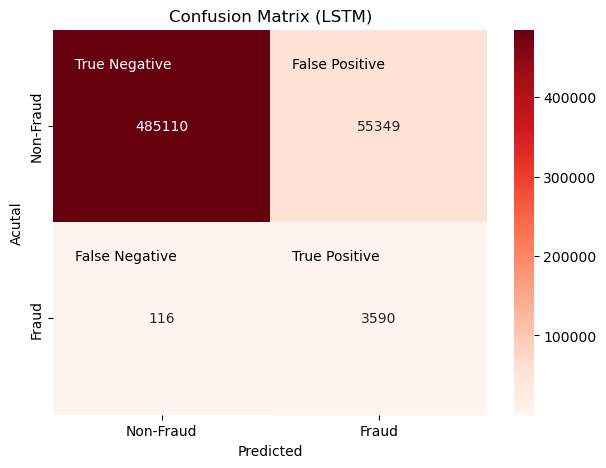

In [197]:
online_cm = confusion_matrix(online_y_test, online_binary_predictions)
# Plot the confusion matrix
plt.figure(figsize=(7,5))
annotations = [f'TN: {online_cm[0,0]}', f'FP: {online_cm[0,1]}'], [f'FN: {online_cm[1,0]}', f'TP: {online_cm[1,1]}']
hm = sns.heatmap(online_cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Acutal')
plt.title('Confusion Matrix (LSTM)')
hm.text(0.1, 0.2, 'True Negative', color='white')
hm.text(1.1, 0.2, 'False Positive')
hm.text(0.1, 1.2, 'False Negative')
hm.text(1.1, 1.2, 'True Positive')
plt.show()

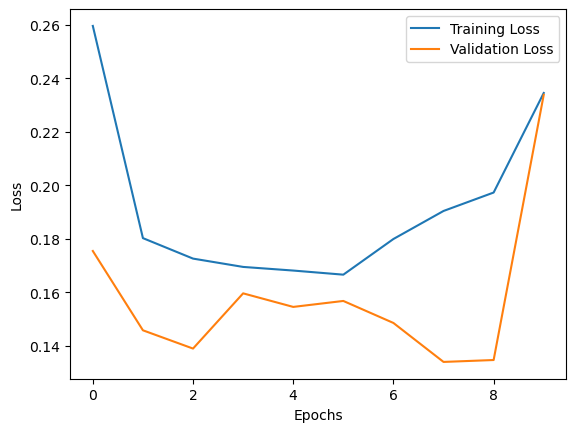

In [138]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(online_history.history['loss'], label='Training Loss')
plt.plot(online_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


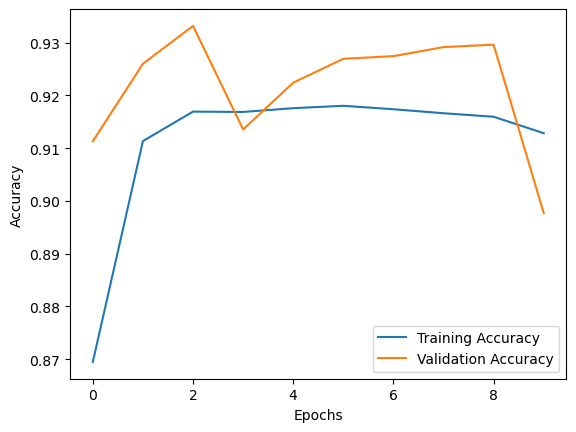

In [139]:

# Plot accuracy
plt.plot(online_history.history['accuracy'], label='Training Accuracy')
plt.plot(online_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


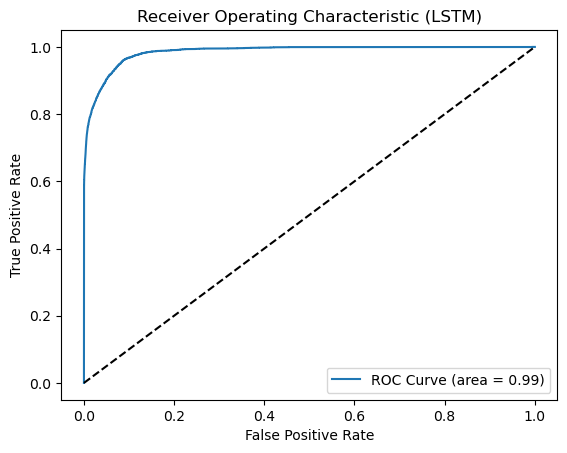

In [194]:
# Get the ROC curve
online_fpr, online_tpr, online_thresholds = roc_curve(online_y_test, online_lstm_pred)
online_roc_auc = auc(online_fpr, online_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(online_fpr, online_tpr, label=f'ROC Curve (area = {online_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (LSTM)')
plt.legend(loc='lower right')
plt.show()


In [141]:
# Save the model
online_lstm_model.save('online_lstm_fraud_model2_user.keras')

# Loading the model
# from tensorflow.keras.models import load_model
# model = load_model('lstm_fraud_model.h5')

## Experimental: Random Undersampling

In [42]:
cc_df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Date,Day of Week,Hour,Minute
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,0,2002-09-01,Sun,6,21
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,0,2002-09-01,Sun,6,42
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,0,2002-09-02,Mon,6,22
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,0,2002-09-02,Mon,17,45
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,0,2002-09-03,Tue,6,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,0,2020-02-27,Thu,22,23
24386896,1999,1,2020,2,27,22:24,54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,0,2020-02-27,Thu,22,24
24386897,1999,1,2020,2,28,07:43,59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,0,2020-02-28,Fri,7,43
24386898,1999,1,2020,2,28,20:10,43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,0,2020-02-28,Fri,20,10


In [43]:
user_df

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Jose Faraday,32,70,1987,7,Male,6577 Lexington Lane,9.0,Freeport,NY,11520,40.65,-73.58,$23550,$48010,$87837,703,3
1996,Ximena Richardson,62,65,1957,11,Female,2 Elm Drive,955.0,Independence,KY,41051,38.95,-84.54,$24218,$49378,$104480,740,4
1997,Annika Russell,47,67,1973,1,Female,276 Fifth Boulevard,NaN,Elizabeth,NJ,7201,40.66,-74.19,$15175,$30942,$71066,779,3
1998,Juelz Roman,66,60,1954,2,Male,259 Valley Boulevard,NaN,Camp Hill,PA,17011,40.24,-76.92,$25336,$54654,$27241,618,1


In [172]:
select_user_cols = ['Current Age', 'Gender', 'State', 'Yearly Income - Person', 'FICO Score', 'Num Credit Cards']

In [173]:
user_df.columns

Index(['Person', 'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month',
       'Gender', 'Address', 'Apartment', 'City', 'State', 'Zipcode',
       'Latitude', 'Longitude', 'Per Capita Income - Zipcode',
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards'],
      dtype='object')

In [175]:
user_df.loc[:,select_user_cols]

,Current Age,Gender,State,Yearly Income - Person,FICO Score,Num Credit Cards
0,53,Female,CA,$59696,787,5
1,53,Female,NY,$77254,701,5
2,81,Female,CA,$33483,698,5
3,63,Female,NY,$249925,722,4
4,43,Male,CA,$109687,675,1
...,...,...,...,...,...,...
1995,32,Male,NY,$48010,703,3
1996,62,Female,KY,$49378,740,4
1997,47,Female,NJ,$30942,779,3
1998,66,Male,PA,$54654,618,1


In [178]:
filter_user = user_df.copy()
filter_user = user_df.loc[:, select_user_cols]

In [179]:
filter_user

,Current Age,Gender,State,Yearly Income - Person,FICO Score,Num Credit Cards
0,53,Female,CA,$59696,787,5
1,53,Female,NY,$77254,701,5
2,81,Female,CA,$33483,698,5
3,63,Female,NY,$249925,722,4
4,43,Male,CA,$109687,675,1
...,...,...,...,...,...,...
1995,32,Male,NY,$48010,703,3
1996,62,Female,KY,$49378,740,4
1997,47,Female,NJ,$30942,779,3
1998,66,Male,PA,$54654,618,1
